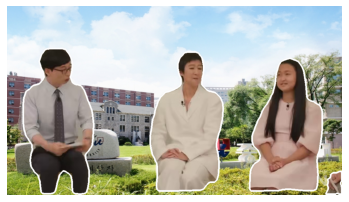

In [60]:
import torchvision
import cv2
from PIL import Image
import random
import numpy as np
from torchvision import transforms as T
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold=0.5, url=False):

    img = Image.open(img_path) # This is for local images
    transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
    img = transform(img)
    img = img.to(device) # Only if GPU, otherwise comment this line
    pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
    #Let's change it to GPU
    # pred = pred.cpu() # We will just send predictions back to CPU
    # Now we need to extract the bounding boxes and masks
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    
    return masks, pred_boxes, pred_class


def random_color_masks(image):
    # I will copy a list of colors here
    colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
    colored_mask = np.stack([r,g,b], axis=2)
    return colored_mask


def instance_segmentation(img_path, threshold=0.5, rect_th=3,
                          text_size=3, text_th=3, url=False):
    masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)
    #print(pred_cls)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
    for i in range(len(masks)):
        if pred_cls[i] == 'person': 
            rgb_mask = random_color_masks(masks[i])
            img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
            mask_list.append(masks[i])
            box_list.append(boxes[i])
    return img, mask_list


def contour_drawing(img, contour_list):
    query_img = img.copy()

    for i in range(len(contour_list)):
        cv2.drawContours(query_img, contour_list[i], -1, (1,1,1), 4)
    return query_img

def masking(query, mask):
    mask = mask.astype(float)
    _, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    
    alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)
    
    alpha = alpha / 255. # (height, width)
    alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)
    #query = query.copy()
    #query = cv2.multiply(0, query.astype(float))
    foreground = cv2.multiply(alpha, query.astype(float))
    
    #fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    #axes[0].imshow(mask)
    #axes[1].imshow(foreground.astype(np.uint8))
    
    return foreground.astype(np.uint8)

def Auto_Resizer(target, background) :
    target_size = target.shape
    background_size = background.shape
    resized_background = cv2.resize(background, dsize = (target.shape[1], target.shape[0]), interpolation = cv2.INTER_CUBIC)
    return resized_background


mask_list = []
box_list = []

img = cv2.imread('./input/query/frame59.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_, masks = instance_segmentation('./input/query/frame59.png')

background = Auto_Resizer(img, cv2.imread('./background/background3.png'))
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)



mask_img = []
contour_list = []

for i in range(len(masks)):
    img2 =  np.zeros_like(img)
    img2[:,:,0] = mask_list[i]*255
    img2[:,:,1] = mask_list[i]*255
    img2[:,:,2] = mask_list[i]*255
    mask_img.append(img2)
    
    imgray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 0, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_list.append(contours)
    
for mask in mask_list:
    mask = mask.astype(float)
    _, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)
    alpha = alpha / 255. # (height, width)
    alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2)
    background = cv2.multiply(1.0-alpha, background.astype(float))

background = background/255

for i in range(len(mask_list)):
    if i == 0:
        new = masking(img, mask_list[0])
    else :
        new = new + masking(img, mask_list[i])

new = new/255+background
new = contour_drawing(new, contour_list)


plt.axis('off')
plt.imshow(new)
plt.savefig('./output/savefig_default.png')

In [61]:
from PIL import Image,ImageDraw,ImageFont,ImageFilter
import os
target_image = Image.fromarray((new*255).astype(np.uint8))
fontsFolder = './fonts/'
selectedFont =ImageFont.truetype(os.path.join(fontsFolder,'aggroM.ttf'),100)
selectedFont_s =ImageFont.truetype(os.path.join(fontsFolder,'aggroM.ttf'),102)

text = '그래서 상주시ㅁㅁㄴㅇㄹㅁㄴㅇㄹ나요?'
x = target_image.width//2
y = target_image.height//1.2

shadowcolor = "purple"
draw = ImageDraw.Draw(target_image)
sf = 3
# thin border
draw.text((x-sf, y), text, font=selectedFont, fill=shadowcolor, anchor='mm')
draw.text((x+sf, y), text, font=selectedFont, fill=shadowcolor, anchor='mm')
draw.text((x, y-sf), text, font=selectedFont, fill=shadowcolor, anchor='mm')
draw.text((x, y+sf), text, font=selectedFont, fill=shadowcolor, anchor='mm')

# thicker border
draw.text((x-sf, y-sf), text, font=selectedFont, fill=shadowcolor, anchor='mm')
draw.text((x+sf, y-sf), text, font=selectedFont, fill=shadowcolor, anchor='mm')
draw.text((x-sf, y+sf), text, font=selectedFont, fill=shadowcolor, anchor='mm')
draw.text((x+sf, y+sf), text, font=selectedFont, fill=shadowcolor, anchor='mm')




draw.text(xy=(x,y), text=text, fill='yellow', font=selectedFont, anchor='mm')

target_image.save('aaa.jpg')